In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

In [54]:
# Load the dataset
data_path = '../data/events.csv'
data = pd.read_csv(data_path)

In [55]:
# Filter data to include only rows with valid shot_place
shots_data = data.dropna(subset=['shot_place'])

In [56]:
# Reduce the dataset size for quicker execution (e.g., 1000 samples), take random 1000 samples
shots_data = shots_data.sample(n=1000, random_state=42)
shots_data

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
763533,MHZSkeoD/,MHZSkeoD88,88,84,"Goal! Nantes 2, Bordeaux 1. Cheick DiabatA© (...",1,12.0,2,Bordeaux,Nantes,...,NaN,NaN,3.0,1.0,1,3.0,3.0,1,2.0,0
143031,CSIVz9Rt/,CSIVz9Rt60,60,77,"Goal! FC Nurnberg 1, Bayer Leverkusen 3. Andr...",1,12.0,2,Bayer Leverkusen,Nurnberg,...,NaN,NaN,3.0,1.0,1,3.0,1.0,4,1.0,0
901230,AT8BU3Vt/,AT8BU3Vt97,97,87,Attempt blocked. Alexandre Mendy (Guingamp) ri...,1,NaN,1,Guingamp,Bordeaux,...,NaN,NaN,2.0,3.0,0,15.0,1.0,0,1.0,0
127033,dfsta8kI/,dfsta8kI38,38,39,Attempt blocked. Alejandro Alfaro (Mallorca) r...,1,12.0,2,Mallorca,Racing Santander,...,NaN,NaN,2.0,3.0,0,15.0,1.0,1,1.0,0
659151,Qa1FLFwr/,Qa1FLFwr20,20,29,Attempt missed. Ola Toivonen (Rennes) right fo...,1,12.0,1,Stade Rennes,Lyon,...,NaN,NaN,9.0,2.0,0,3.0,1.0,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480747,MqnbIx1i/,MqnbIx1i89,89,78,Attempt missed. Victor Obinna (Chievo) right f...,1,12.0,1,Chievo Verona,Internazionale,...,NaN,NaN,6.0,2.0,0,15.0,1.0,1,1.0,0
742579,xlW8CFLs/,xlW8CFLs30,30,33,Attempt missed. Papiss Demba Cisse (Newcastle ...,1,12.0,2,Newcastle,Tottenham,...,NaN,NaN,8.0,2.0,0,3.0,3.0,2,1.0,0
283432,tA4mzHyL/,tA4mzHyL29,29,30,Attempt missed. Edinson Cavani (Napoli) right ...,1,12.0,1,Napoli,Cagliari,...,NaN,NaN,10.0,2.0,0,3.0,1.0,3,1.0,0
485751,OIosWf81/,OIosWf8162,62,53,Attempt missed. Haris Seferovic (Eintracht Fra...,1,12.0,1,Eintracht Frankfurt,SC Freiburg,...,NaN,NaN,9.0,2.0,0,15.0,2.0,1,1.0,0


In [57]:
print("Reduced dataset shape:", shots_data.shape)

Reduced dataset shape: (1000, 22)


In [58]:
# Define features to include
categorical_columns = ['side', 'bodypart', 'assist_method', 'situation', 'fast_break', 'event_team', 'opponent']
numerical_columns = ['time', 'shot_outcome', 'location', 'is_goal']

In [59]:
# Handle missing values in numerical columns
shots_data[numerical_columns] = shots_data[numerical_columns].fillna(shots_data[numerical_columns].mean())
print("Data after filling missing values:")
print(shots_data.head())

Data after filling missing values:
          id_odsp    id_event  sort_order  time  \
763533  MHZSkeoD/  MHZSkeoD88          88    84   
143031  CSIVz9Rt/  CSIVz9Rt60          60    77   
901230  AT8BU3Vt/  AT8BU3Vt97          97    87   
127033  dfsta8kI/  dfsta8kI38          38    39   
659151  Qa1FLFwr/  Qa1FLFwr20          20    29   

                                                     text  event_type  \
763533  Goal!  Nantes 2, Bordeaux 1. Cheick DiabatA© (...           1   
143031  Goal!  FC Nurnberg 1, Bayer Leverkusen 3. Andr...           1   
901230  Attempt blocked. Alexandre Mendy (Guingamp) ri...           1   
127033  Attempt blocked. Alejandro Alfaro (Mallorca) r...           1   
659151  Attempt missed. Ola Toivonen (Rennes) right fo...           1   

        event_type2  side        event_team          opponent  ... player_in  \
763533         12.0     2          Bordeaux            Nantes  ...       NaN   
143031         12.0     2  Bayer Leverkusen          Nurnbe

In [60]:
# Preprocessing: One-hot encode categorical and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

In [61]:
# Apply preprocessing
processed_data = preprocessor.fit_transform(shots_data).toarray()
print("Processed data shape:", processed_data.shape)

Processed data shape: (1000, 290)


In [62]:
processed_data

array([[ 1.3087815 , -1.17481688, -1.36363854, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.04767424, -1.17481688, -1.36363854, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.42068461,  1.37359284,  0.92594625, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.70547452,  0.09938798, -1.36363854, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15244934,  0.09938798,  0.92594625, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33895453, -1.17481688,  0.92594625, ...,  0.        ,
         0.        ,  0.        ]])

In [63]:
# Perform OPTICS clustering
optics_model = OPTICS(min_samples=5, metric='euclidean', cluster_method='xi')
print("Fitting OPTICS model...")
optics_model.fit(processed_data)
print("OPTICS clustering complete.")

Fitting OPTICS model...
OPTICS clustering complete.


In [64]:
# Extract clustering labels
labels = optics_model.labels_
print("Cluster labels:", labels[:10])  # Display the first 10 labels

Cluster labels: [ 0  0 -1 -1 -1 -1 -1 -1 -1 -1]


In [65]:
# Add cluster labels back to the original dataset
shots_data['cluster'] = labels
print("Data with clusters:")
print(shots_data[['shot_place', 'cluster']].head())

Data with clusters:
        shot_place  cluster
763533         3.0        0
143031         3.0        0
901230         2.0       -1
127033         2.0       -1
659151         9.0       -1


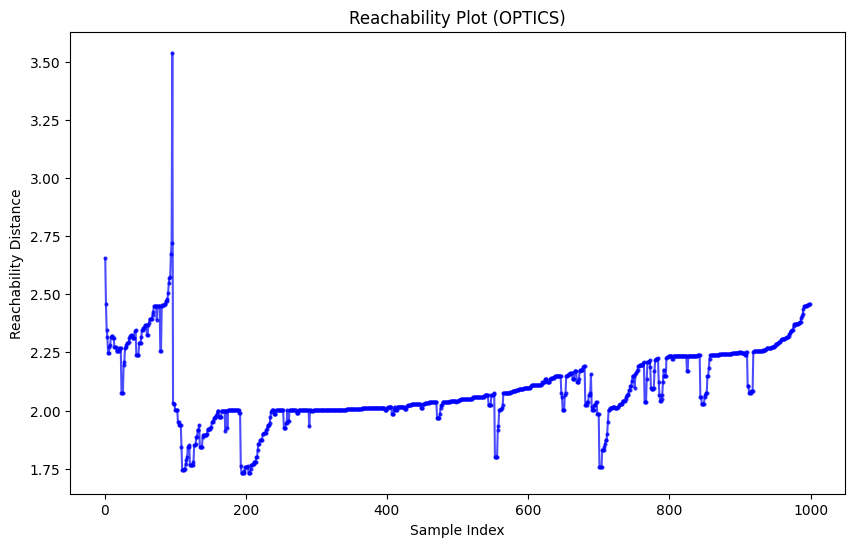

In [66]:
# Visualize the reachability plot
plt.figure(figsize=(10, 6))
space = range(processed_data.shape[0])
reachability = optics_model.reachability_[optics_model.ordering_]
plt.plot(space, reachability, marker='o', markersize=2, color='blue', alpha=0.7)
plt.title('Reachability Plot (OPTICS)')
plt.xlabel('Sample Index')
plt.ylabel('Reachability Distance')
plt.show()

In [67]:
# Analyze the clustering results
unique_labels = set(labels)
print(f"Clusters found: {unique_labels}")

Clusters found: {0, 1, 2, -1}


In [68]:
# Compute silhouette score (if there are clusters)
if len(unique_labels) > 1 and -1 in labels:
    filtered_labels = labels[labels >= 0]
    filtered_data = processed_data[labels >= 0]
    silhouette = silhouette_score(filtered_data, filtered_labels)
    print(f"Silhouette Score: {silhouette:.4f}")
else:
    print("Silhouette Score cannot be computed with fewer than 2 clusters.")

Silhouette Score: 0.2995


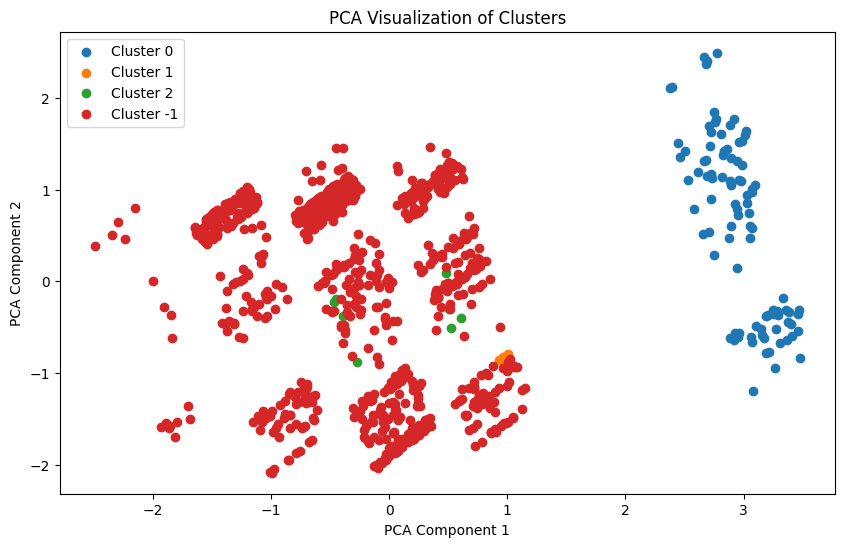

In [69]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(processed_data)
plt.figure(figsize=(10, 6))
for cluster in unique_labels:
    cluster_data = pca_data[labels == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')
plt.title('PCA Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [70]:
# Analyze shot_place proportions within each cluster
cluster_proportions = shots_data.groupby('cluster')['shot_place'].value_counts(normalize=True).unstack(fill_value=0)
print("Proportion of shot_place in each cluster:")
print(cluster_proportions)

Proportion of shot_place in each cluster:
shot_place      1.0       2.0       3.0       4.0       5.0       6.0   \
cluster                                                                  
-1          0.035955  0.248315  0.050562  0.060674  0.104494  0.076404   
 0          0.000000  0.000000  0.302083  0.322917  0.218750  0.000000   
 1          0.000000  0.000000  0.400000  0.000000  0.600000  0.000000   
 2          0.000000  0.000000  0.111111  0.111111  0.000000  0.000000   

shot_place      7.0       8.0       9.0       10.0      11.0      12.0  \
cluster                                                                  
-1          0.019101  0.142697  0.126966  0.075281  0.017978  0.021348   
 0          0.000000  0.000000  0.000000  0.000000  0.000000  0.104167   
 1          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 2          0.000000  0.222222  0.111111  0.111111  0.000000  0.222222   

shot_place      13.0  
cluster               
-1          0.020225  

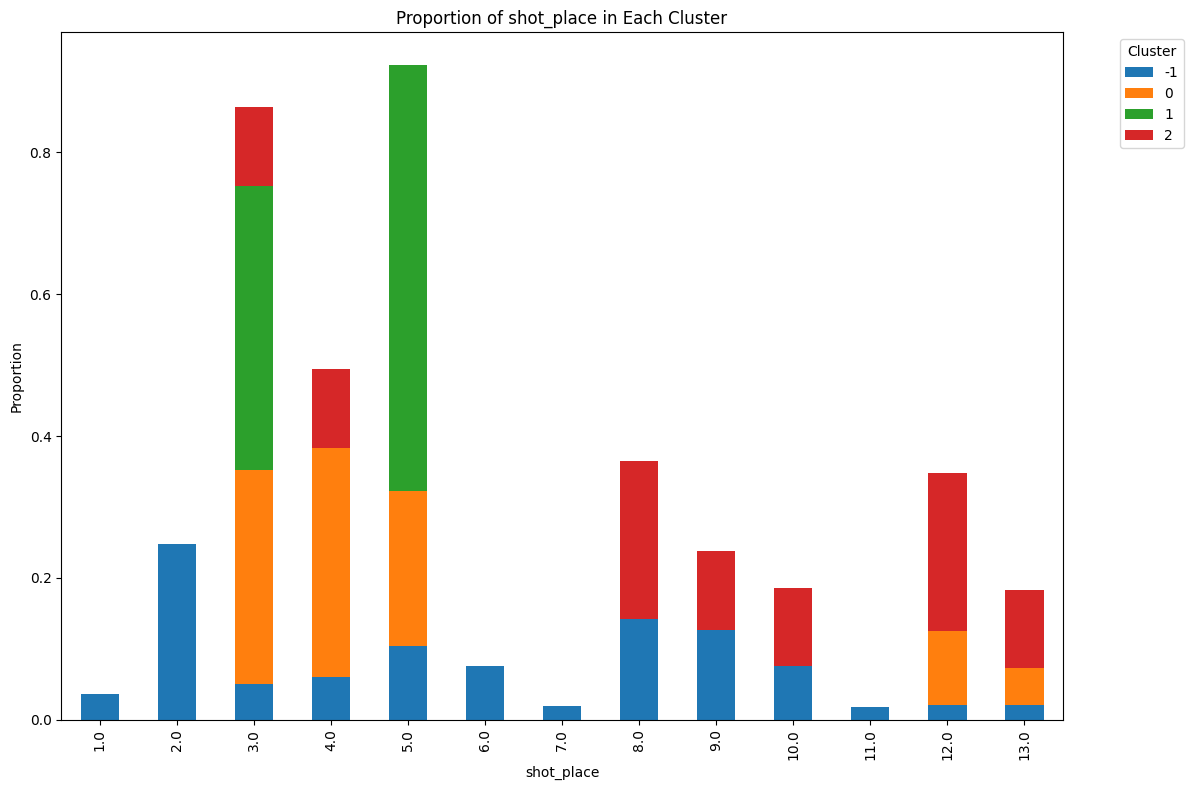

In [71]:
# Plot shot_place proportions for each cluster
cluster_proportions.T.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Proportion of shot_place in Each Cluster')
plt.xlabel('shot_place')
plt.ylabel('Proportion')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [72]:
# Save the clustered data for supervised comparison
shots_data.to_csv('clustered_shots.csv', index=False)
print("Clustered data saved to 'clustered_shots.csv'.")

Clustered data saved to 'clustered_shots.csv'.


In [73]:
# For curiosity, out of the 10000 samples, how many are from each shot_place? I want to know if it is balanced
shots_data['shot_place'].value_counts()

shot_place
2.0     221
8.0     129
5.0     117
9.0     114
4.0      86
3.0      77
10.0     68
6.0      68
1.0      32
12.0     31
13.0     24
7.0      17
11.0     16
Name: count, dtype: int64